# 导入相应的库

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 11)  #set default figure size
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, DotProduct, ConstantKernel as C
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error,r2_score
import matplotlib.pylab as plt
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import RandomizedSearchCV  
from scipy.stats import uniform  

# MAPE

In [44]:
def split(xx, yy):      #定义一个函数用来划分训练集，测试集，验证集
    zscore = StandardScaler()   #用于数据标准化处理的缩放器
    scaler =MinMaxScaler()   #用于数据最小最大缩放处理的缩放器
    xx = zscore.fit_transform(xx)  
    yy = scaler.fit_transform(np.reshape(yy.values,(len(yy),1))) 
    
    x_train, x_test_val, y_train, y_test_val = train_test_split(xx, yy, shuffle=True,test_size=0.3, random_state=1)
    #x_训练集，x_测试验证集，y_训练集，y_测试验证集                    划分前将数据集进行随机打乱，并按照6：4划分，且划分方式统一
    x_test, x_val, y_test, y_val = train_test_split(x_test_val, y_test_val, shuffle=True,test_size=0.25, random_state=1)
    #x_测试集，x_验证集，y_测试集，y_验证集                           划分前将数据集进行随机打乱，并按照3：1划分，且划分方式统一
    
    y2 = yy.ravel()     #将yy数组转化为一维数组并存在y2中
    ind_train = [np.argwhere(y2 == y_train[i])[0].item() for i in range(len(y_train)) if y_train[i] in y2]
                                                        #这是一个循环，遍历y_train中的每一个元素，判断y_train中的当前标签y_train[i]是否存在于y2中
                #找到y2中所有等于y_train[i]的元素的索引，返回一个二维数组，然后用[0].item()取得第一行赋值给ind_train生成列表
    ind_test = [np.argwhere(y2 == y_test[i])[0].item() for i in range(len(y_test)) if y_test[i] in y2]
    ind_val = [np.argwhere(y2 == y_val[i])[0].item() for i in range(len(y_val)) if y_val[i] in y2]
   
    y_train = y_train.ravel()       #将y_train数组转化为一维数组
    y_test = y_test.ravel()         #将y_text数组转化为一维数组
    y_val = y_val.ravel()           #将y_val数组转化为一维数组
    
    return x_train, x_test, x_val, y_train, y_test, y_val, xx, yy, np.asarray(ind_train), np.asarray(ind_train), np.asarray(ind_val)
    #返回训练集，测试集，验证集的特征数据，和标签（目标变量）数据，原特数据，原目标变量数据，以及转化为数组的ind_train，ind_train，ind_val

In [45]:
df = pd.read_csv('MP_data_0421_C(A).csv', index_col=None, engine='c') 
print('original datasize:', df.shape)
df.dropna(inplace=True)
print('adjusted datasize:', df.shape)
print('data:')
print(df.head())

original datasize: (222, 17)
adjusted datasize: (222, 17)
data:
   Time  Deep  Length   HRT     COD    TN  NH4-N    C/N    c(A)  CSC  XLogP3  \
0    90  12.5    45.0  72.0  299.46  26.8  24.07  11.17  100.00   11    -0.1   
1    90  45.0    12.5  72.0  299.46  26.8  24.07  11.17  100.00   11    -0.1   
2    84  10.0    30.0  72.0   66.60   3.6   2.35  18.50    0.18   11     0.2   
3    84  10.0    90.0  72.0   66.60   3.6   2.35  18.50    0.18   11     0.2   
4    84  50.0    30.0  72.0   66.60   3.6   2.35  18.50    0.18   11     0.2   

    WI    RA(P)   RA(F)    RA(B)   RA(A)   RR（A）  
0  885  48.0057  1.8966   9.9499  2.3363  0.9893  
1  885  62.3032  1.6632   6.7403  0.9921  0.9893  
2  943  50.8357  0.9988  10.7969  7.0869  0.7094  
3  943  46.2696  1.4269  11.2249  2.6160  0.7094  
4  943  38.7070  0.6659   6.9918  1.5220  0.7094  


In [46]:
xx= df.iloc[:,0:-1] # predictors
yy=df.iloc[:,-1]# target - kd
x_train, x_test,x_val, y_train, y_test,y_val, x_scaled, y_scaled, ind_train, ind_test,ind_val = split(xx, yy)

print('目标变量是 ', yy.name)
print('特征变量是 ', xx.columns.tolist())
print('样本大小 is ', xx.shape[0], '; 特征变量的数量 is ', xx.shape[1])
print('训练集数据大小 is ', x_train.shape[0], '; 测试集数据大小 is ', x_test.shape[0],'; 验证集数据大小 is ', x_val.shape[0])

目标变量是  RR（A）
特征变量是  ['Time', 'Deep', 'Length', 'HRT', 'COD', 'TN', 'NH4-N', 'C/N', 'c(A)', 'CSC', 'XLogP3', 'WI', 'RA(P)', 'RA(F)', 'RA(B)', 'RA(A)']
样本大小 is  222 ; 特征变量的数量 is  16
训练集数据大小 is  155 ; 测试集数据大小 is  50 ; 验证集数据大小 is  17


In [47]:
#d = np.ones(x_train.shape[1])
# 定义核函数，包括边界  
kernel = C(1, (1e-3, 1e3)) * RBF(16,(1e-9, 1e9)) + WhiteKernel(noise_level=1)
gpr = GaussianProcessRegressor(kernel=kernel, random_state=42, n_restarts_optimizer=10).fit(x_train, y_train)

In [48]:
y_pred_train = gpr.predict(x_train)    
y_pred_test = gpr.predict(x_test)    
y_pred_val = gpr.predict(x_val) 

# 评估模型性能  

In [49]:
# 交叉验证得分  
scores = cross_val_score(gpr, x_train, y_train, cv=5)  
print("Mean cross-validation score: %.2f" % scores.mean())  

print('GPR training\tR2:{:.4f}\t\tMSE:{:.6f}\t\tMAE:{:.6f}'.format(gpr.score(x_train,y_train), mean_squared_error(y_train, y_pred_train),
                                                        mean_absolute_error(y_train, y_pred_train)))
print('GPR test  \t\tR2:{:.4f}\t\tMSE:{:.6f}\t\tMAE:{:.6f}'.format(gpr.score(x_test,y_test), mean_squared_error(y_test, y_pred_test),
                                                        mean_absolute_error(y_test, y_pred_test)))

print('GPR valid \t\tR2:{:.4f}\t\tMSE:{:.6f}\t\tMAE:{:.6f}'.format(gpr.score(x_val,y_val), mean_squared_error(y_val, y_pred_val),
                                                        mean_absolute_error(y_val, y_pred_val)))

Mean cross-validation score: 0.84
GPR training	R2:0.9634		MSE:0.006567		MAE:0.051219
GPR test  		R2:0.8513		MSE:0.026840		MAE:0.103130
GPR valid 		R2:0.8966		MSE:0.021145		MAE:0.111338


# 生成预测值与实际值之间的散点图

In [50]:
def scatter_plots(model_name, y_pred_train, y_pred_test,y_pred_val, y_train, y_test, y_val):  
    
    plt.figure(figsize=(6, 6))     # 设置图的大小 
    
    # 在同一个图中绘制所有点的散点图  
    plt.scatter(y_train, y_pred_train, color='blue', label='Train', alpha=0.6)  
                                 #散点的颜色设置为蓝色，标签设置为‘Train’，散点的透明度设置为0.6
    plt.scatter(y_test, y_pred_test, color='green', label='Test', alpha=0.6)  
    plt.scatter(y_val, y_pred_val, color='red', label='Validation', alpha=0.6)  
      
    # 绘制完美拟合线  
    limits = [  
        min(y_train.min(), y_test.min(), y_val.min()),  # x min  
        max(y_train.max(), y_test.max(), y_val.max()),  # x max  
        min(y_pred_train.min(), y_pred_test.min(), y_pred_val.min()),  # y min  
        max(y_pred_train.max(), y_pred_test.max(), y_pred_val.max()),  # y max  
    ]  
    plt.plot(limits[:2], limits[2:], 'k--', lw=2)  
      
    # 设置图的标题和坐标轴标签  
    plt.title('GPR-C(A)')     #图片标题
    plt.xlabel('Actual Values')     #x轴标题
    plt.ylabel('Predicted Values')      #y轴标题
    
    # 禁用网格  
    plt.grid(False)       
    # 显示图例  
    plt.legend()  
      
    # 显示图形  
    plt.show()  

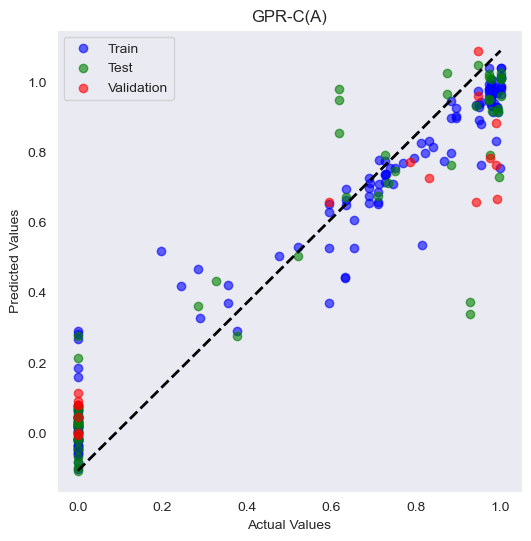

In [51]:
# 调用scatter_plots函数生成图像
scatter_plots('GPR', y_pred_train, y_pred_test, y_pred_val, y_train, y_test, y_val)

In [52]:
import pickle
# save gpr model
model_name = 'gpr.pkl' # 模型名称.plk
path =''
with open(path+'gpr.pkl','wb') as f:
    pickle.dump(gpr, f)

In [53]:
y_train

array([0.    , 0.    , 0.631 , 0.5948, 0.7287, 0.983 , 0.954 , 0.4768,
       0.9536, 1.    , 0.653 , 0.8315, 0.    , 0.    , 0.    , 0.    ,
       0.5948, 0.7094, 0.5201, 0.    , 0.7132, 0.9787, 0.9784, 0.8118,
       0.6903, 0.    , 0.653 , 1.    , 0.    , 0.    , 0.8653, 0.    ,
       0.7276, 0.9844, 0.    , 0.6343, 1.    , 0.    , 0.9489, 0.    ,
       0.895 , 0.7506, 0.    , 0.    , 0.    , 0.6343, 0.7683, 0.    ,
       0.2431, 1.    , 0.7947, 0.    , 0.    , 0.8134, 0.    , 0.9787,
       0.    , 0.9717, 0.882 , 0.3548, 0.    , 1.    , 0.7387, 0.9717,
       0.7094, 0.9417, 0.6893, 0.7276, 0.895 , 0.631 , 0.1957, 0.9784,
       0.    , 0.3765, 0.9844, 1.    , 0.    , 0.    , 0.    , 0.6343,
       0.9472, 0.8215, 0.    , 0.9489, 0.    , 0.    , 0.983 , 0.    ,
       0.6893, 0.7276, 0.955 , 1.    , 0.9717, 0.    , 0.2891, 0.    ,
       0.9784, 0.5948, 0.9894, 0.9489, 0.    , 0.    , 0.285 , 0.9724,
       0.3545, 0.    , 0.9724, 0.7094, 0.7276, 0.7132, 1.    , 0.9909,
      

In [54]:
y_pred_train

array([-2.30643854e-02,  1.75863375e-02,  4.44324683e-01,  5.26234486e-01,
        7.37026113e-01,  9.65921539e-01,  9.43077346e-01,  5.02831756e-01,
        8.79399358e-01,  9.77850503e-01,  6.04796762e-01,  8.31667417e-01,
        4.79301333e-02,  2.52544471e-03,  3.76186448e-02, -5.12749986e-02,
        6.50975544e-01,  6.53003040e-01,  5.28382071e-01,  2.48075108e-02,
        7.09561486e-01,  9.63225888e-01,  9.81383388e-01,  8.24118121e-01,
        7.12010776e-01, -3.49161554e-02,  5.25455527e-01,  1.03903058e+00,
       -1.01885692e-01,  2.28507993e-02,  7.74489069e-01, -4.27954408e-02,
        7.72896694e-01,  9.83596369e-01, -3.52559995e-02,  6.93688473e-01,
        9.86311949e-01,  6.93989902e-02,  9.27144145e-01,  1.65753848e-02,
        8.96749626e-01,  7.54268454e-01, -4.76570143e-02, -5.49038498e-03,
       -3.48990085e-04,  6.62463335e-01,  7.67666656e-01, -4.17221460e-02,
        4.18038166e-01,  1.01084025e+00,  7.82172461e-01,  2.20501574e-02,
        4.60027898e-04,  

In [55]:
y_test

array([0.    , 0.    , 0.882 , 0.    , 1.    , 0.6188, 0.    , 1.    ,
       0.    , 0.6343, 1.    , 0.8728, 0.5201, 0.    , 0.7347, 0.    ,
       0.6188, 0.9787, 0.    , 0.    , 0.9417, 0.    , 0.9276, 1.    ,
       0.    , 0.    , 0.3279, 0.6188, 0.    , 0.9729, 0.    , 0.9724,
       0.    , 0.3765, 0.285 , 0.9935, 0.9276, 0.9784, 0.8728, 0.9747,
       0.    , 0.9472, 0.    , 0.9935, 0.9729, 0.7506, 0.7276, 0.7094,
       0.9971, 0.9729])

In [56]:
y_pred_test

array([ 2.12088317e-01,  2.74561817e-01,  7.62549954e-01, -9.82767172e-02,
        1.02426492e+00,  9.78097280e-01,  1.60350365e-02,  1.00676231e+00,
       -2.42554908e-02,  6.71314327e-01,  1.01020643e+00,  1.02581894e+00,
        5.02780106e-01,  4.17052195e-02,  7.10052246e-01,  2.82353592e-02,
        8.53457040e-01,  9.15344852e-01,  5.09461618e-02,  6.58020337e-02,
        9.31865401e-01, -4.48660795e-02,  3.37843809e-01,  9.58553574e-01,
       -6.98968752e-02, -1.59444997e-02,  4.31219374e-01,  9.47038427e-01,
       -5.76716165e-04,  9.50682916e-01,  7.29912613e-02,  9.48538394e-01,
       -1.08048019e-01,  2.76192281e-01,  3.62486501e-01,  9.12769245e-01,
        3.71104156e-01,  1.00769288e+00,  9.65872990e-01,  7.90250436e-01,
        2.74074713e-02,  1.04788953e+00, -8.27973243e-02,  9.22784723e-01,
        1.01345996e+00,  7.46790274e-01,  7.92011806e-01,  6.75157698e-01,
        7.29624302e-01,  1.02253384e+00])

In [57]:
y_val

array([0.    , 0.974 , 0.9901, 0.8315, 0.    , 0.9472, 0.    , 0.5948,
       0.786 , 0.9417, 0.    , 0.    , 0.    , 0.9909, 0.9893, 0.9472,
       0.    ])

In [58]:
y_pred_val

array([ 0.11461422,  0.78199715,  0.88298336,  0.72497886, -0.00178726,
        1.08819104,  0.09017002,  0.65827535,  0.77000753,  0.65593806,
        0.04609572,  0.07812404, -0.00521045,  0.66520845,  0.76145875,
        0.9591975 ,  0.07935084])